<img align="right" src="https://druggablegenome.net/IDG_Images_Index/IDGLOGO.png" width="400">

# Pharos API Introduction
 * https://pharos.nih.gov
 * https://pharos.nih.gov/api
 * https://spotlite.nih.gov/ncats/pharos/snippets (Dac Trung Ngyuen)

### Imports and BASE_URL

In [0]:
import sys, json, urllib.request
import pandas
import matplotlib.pyplot
import altair #Ok for Colaboratory, not GitHub
BASE_URL = 'https://pharos.nih.gov/idg/api/v1'

### List target Collections:

In [2]:
req = urllib.request.urlopen(BASE_URL + '/targets/Collection/termvec')
termvec = json.loads(req.read())
for i,term in enumerate(termvec['terms']):
  tids = termvec['terms'][term]['docs'] #target IDs
  print("%d. TERM: \"%s\" (%d targets)"%(i+1, term, len(tids)))

1. TERM: "GPCR: IDG Consortium (Complete/Control)" (25 targets)
2. TERM: "GPCR: IDG Consortium (Targets)" (126 targets)
3. TERM: "Ion Channel: IDG Consortium (Targets)" (99 targets)
4. TERM: "Kinase: IDG Consortium (Complete/Control)" (37 targets)
5. TERM: "Kinase: IDG Consortium (Targets)" (125 targets)


### Fetch collection of IDG high-priority targets: 

In [0]:
term = 'Ion Channel: IDG Consortium (Targets)'
tids = termvec['terms'][term]['docs']
tgts = []
for tid in tids:
  req = urllib.request.urlopen(BASE_URL+'/targets('+str(tid)+')')
  tgts.append(json.loads(req.read().decode('utf8')))

### Dataframe with useful columns, indexed by target ID.

In [13]:
targets = pandas.DataFrame(tgts)
for col in targets.columns:
  if col.startswith('_'): targets.drop(columns=col, inplace=True)
targets.drop(columns=['self', 'kind', 'created', 'modified', 'deprecated', 'version', 'description', 'grantCount', 'grantTotalCost', 'pubmedCount', 'r01Count'], inplace=True)
targets.set_index('id', inplace=True, drop=True)
targets.head()

,name,accession,gene,idgFamily,idgTDL,novelty,antibodyCount,monoclonalCount,jensenScore,patentCount,ppiCount,knowledgeAvailability,pubTatorScore
id,,,,,,,,,,,,,
11776,Leucine-rich repeat-containing protein 38,Q5VT99,LRRC38,Ion Channel,Tbio,0.346787,65,0,0.342857,45.0,NaN,15.155282,-0.397940
6147,Acetylcholine receptor subunit delta,Q07001,CHRND,Ion Channel,Tclin,-1.301542,155,11,18.911755,853.0,54.0,29.076582,1.077485
4867,Chloride intracellular channel protein 5,Q9NZA1,CLIC5,Ion Channel,Tbio,-0.972295,179,107,9.779901,1412.0,2.0,38.607881,1.013222
18956,Potassium voltage-gated channel subfamily H me...,Q96L42,KCNH8,Ion Channel,Tclin,-0.661097,64,6,4.854944,17499.0,NaN,31.375086,0.223072
5901,Amiloride-sensitive sodium channel subunit beta,P51168,SCNN1B,Ion Channel,Tclin,-1.753736,316,60,52.596674,2046.0,1.0,35.627546,1.803175


### Counts and stats:

In [14]:
targets.idgFamily.value_counts()

Ion Channel    99
Name: idgFamily, dtype: int64

In [15]:
targets.idgTDL.value_counts()

Tbio     46
Tclin    24
Tdark    15
Tchem    14
Name: idgTDL, dtype: int64

In [8]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126 entries, 3584 to 17407
Data columns (total 13 columns):
name                     126 non-null object
accession                126 non-null object
gene                     126 non-null object
idgFamily                126 non-null object
idgTDL                   126 non-null object
novelty                  123 non-null float64
antibodyCount            126 non-null int64
monoclonalCount          126 non-null int64
jensenScore              126 non-null float64
patentCount              124 non-null float64
ppiCount                 21 non-null float64
knowledgeAvailability    126 non-null float64
pubTatorScore            125 non-null float64
dtypes: float64(6), int64(2), object(5)
memory usage: 13.8+ KB


In [16]:
targets.describe().round(2)

,novelty,antibodyCount,monoclonalCount,jensenScore,patentCount,ppiCount,knowledgeAvailability,pubTatorScore
count,96.00,99.00,99.00,99.00,91.00,43.00,99.00,98.00
mean,-1.01,106.25,16.63,18.33,2925.26,14.81,28.04,0.89
std,0.56,70.28,29.05,20.78,5647.86,19.48,7.61,0.57
min,-2.03,0.00,0.00,0.00,45.00,1.00,4.83,-0.60
25%,-1.46,68.00,0.00,3.71,508.50,2.00,23.02,0.63
50%,-1.04,92.00,2.00,10.52,1278.00,4.00,28.31,1.00
75%,-0.64,139.00,20.00,25.17,2732.00,24.50,32.45,1.30
max,0.35,471.00,151.00,95.16,42817.00,70.00,45.70,1.80


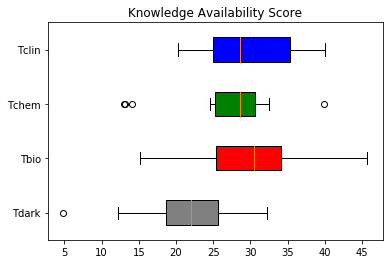

In [17]:
tdls = ["Tdark", "Tbio", "Tchem", "Tclin"]
tdl_colors = ["gray", "red", "green", "blue"]
data = [targets.knowledgeAvailability[targets.idgTDL==tdl] for tdl in tdls]
fig, ax = matplotlib.pyplot.subplots()
ax.set_title('Knowledge Availability Score')
plot = ax.boxplot(data, labels=tdls, vert=False, patch_artist=True)
for patch, color in zip(plot['boxes'], tdl_colors):
  patch.set_facecolor(color)
matplotlib.pyplot.show()

### Knowledge Availability Score distributions plot

In [18]:
lower_box = 'q1(knowledgeAvailability):Q'
lower_whisker = 'min(knowledgeAvailability):Q'
upper_box = 'q3(knowledgeAvailability):Q'
upper_whisker = 'max(knowledgeAvailability):Q'
tdls = ['Tdark','Tbio', 'Tchem', 'Tclin']
palette = altair.Scale(domain=tdls, range=['gray', 'red', 'green', 'blue'])
colors = altair.Color('idgTDL', scale=palette)
plot = altair.Chart(targets, title="Knowledge Availability Score (KAS)").mark_rule().encode(
    x=altair.X(lower_whisker, axis=altair.Axis(title="KAS")),
    x2=lower_box,
    y=altair.Y('idgTDL', sort=tdls)
)
plot += altair.Chart(targets).mark_bar(size=10).encode(
    x=lower_box,
    x2=upper_box,
    y=altair.Y('idgTDL', sort=tdls),
    color=colors
)
plot += altair.Chart(targets).mark_rule().encode(
    x=upper_whisker,
    x2=upper_box,
    y=altair.Y('idgTDL', sort=tdls),
    color=colors
)
plot += altair.Chart(targets).mark_tick(color='white', size=10).encode(
    x='median(knowledgeAvailability):Q',
    y=altair.Y('idgTDL', sort=tdls)
)
plot

alt.LayerChart(...)